### Predicting The Sales Prices of Bulldozers Using Machine Learning Regression Models

1. Problem Definition
How well can we predict the future sale price of a Bulldozer, given it charecteristics and previous examples of how much similar bulldozers have been sold for.

2. Data
Kaggle.com - Bluebook for Bulldozers competition
3 datasets:
* train.csv = trainin set containing data through the end of 2011
* valid.csv = validation set, contains data from 01/01/2012 - 30/04/2012
* test.csv = test set, 1/5/2012 - 09/2012

3. Evaluation
Root Mean Square Log Error (RMSLE) between actual vs predicted prices

4. Features
Kaggle provides data dictionary detailing the datasets features.

## Import Statements

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn

In [2]:
#Import training and validation sets
df = pd.read_csv('bluebook-for-bulldozers/TrainAndValid.csv',
                low_memory=False)
#Low memory = false -- don't worry about minimising space

In [3]:
#Get info on what is happening
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412698 entries, 0 to 412697
Data columns (total 53 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   SalesID                   412698 non-null  int64  
 1   SalePrice                 412698 non-null  float64
 2   MachineID                 412698 non-null  int64  
 3   ModelID                   412698 non-null  int64  
 4   datasource                412698 non-null  int64  
 5   auctioneerID              392562 non-null  float64
 6   YearMade                  412698 non-null  int64  
 7   MachineHoursCurrentMeter  147504 non-null  float64
 8   UsageBand                 73670 non-null   object 
 9   saledate                  412698 non-null  object 
 10  fiModelDesc               412698 non-null  object 
 11  fiBaseModel               412698 non-null  object 
 12  fiSecondaryDesc           271971 non-null  object 
 13  fiModelSeries             58667 non-null   o

412698 rows, 53 columns

In [4]:
#Find missing values
df.isna().sum()
#We will need to take care of these before building our model

SalesID                          0
SalePrice                        0
MachineID                        0
ModelID                          0
datasource                       0
auctioneerID                 20136
YearMade                         0
MachineHoursCurrentMeter    265194
UsageBand                   339028
saledate                         0
fiModelDesc                      0
fiBaseModel                      0
fiSecondaryDesc             140727
fiModelSeries               354031
fiModelDescriptor           337882
ProductSize                 216605
fiProductClassDesc               0
state                            0
ProductGroup                     0
ProductGroupDesc                 0
Drive_System                305611
Enclosure                      334
Forks                       214983
Pad_Type                    331602
Ride_Control                259970
Stick                       331602
Transmission                224691
Turbocharged                331602
Blade_Extension     

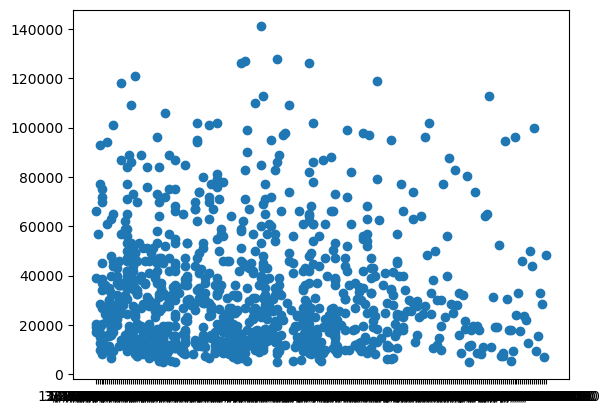

In [5]:
#Set up a plot to create visualisations
fig, ax = plt.subplots()
#Look at the first 1000 otherwise it'll be too much data on one plot
#Sale date, Sale Price
ax.scatter(df["saledate"][:1000], df["SalePrice"][:1000])

<Axes: ylabel='Frequency'>

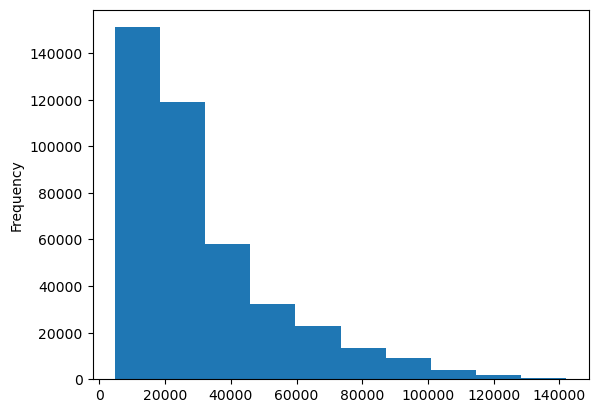

In [6]:
#Plotting a histogram to check the spread of data for our target variable, Sale Price
df.SalePrice.plot.hist()

## Parsing Dates
When we work with time series data, we want to enrich the time and date component as much as possible:
1. Tell pandas which of our columns has dates using the parse_dates parameter

In [7]:
#Importing data with parse_dates
df = pd.read_csv('bluebook-for-bulldozers/Train.csv',
                low_memory=False,
                parse_dates=['saledate'])

In [8]:
df.saledate.dtype

dtype('<M8[ns]')

In [9]:
df.saledate[:10]

0   2006-11-16
1   2004-03-26
2   2004-02-26
3   2011-05-19
4   2009-07-23
5   2008-12-18
6   2004-08-26
7   2005-11-17
8   2009-08-27
9   2007-08-09
Name: saledate, dtype: datetime64[ns]

Saledates has been converted into time and dates using parse_dates

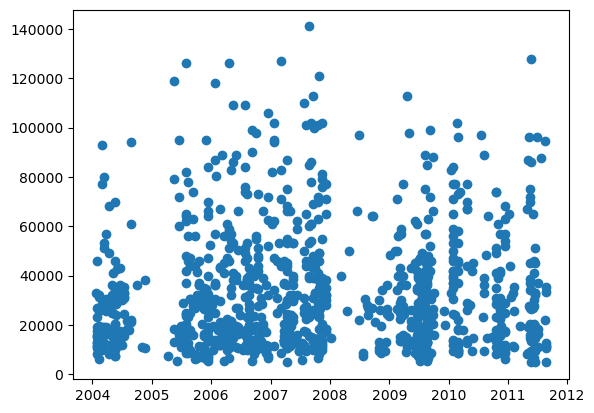

In [10]:
fix, ax = plt.subplots()
ax.scatter(df['saledate'][:1000], df['SalePrice'][:1000])

Interpretation:
Very few sales in 2005, 2008
Higest sale in 2007

In [11]:
#Sort DataFrame by saledate
df.sort_values(by=['saledate'],
               inplace=True,
               ascending=True)

In [12]:
df.saledate.head()

205615   1989-01-17
92803    1989-01-31
98346    1989-01-31
169297   1989-01-31
274835   1989-01-31
Name: saledate, dtype: datetime64[ns]

### Make a copy of the original data frame
= so when we manipulate the copy, we still have the original data

In [13]:
df_copy = df.copy()

In [14]:
df_copy.saledate.head()

205615   1989-01-17
92803    1989-01-31
98346    1989-01-31
169297   1989-01-31
274835   1989-01-31
Name: saledate, dtype: datetime64[ns]

## Feature Engineering
Creating new features or playing with existing features

In [15]:
## Add datetime parameters for saledate column
#Accessing the year
df_copy['saleYear'] = df_copy['saledate'].dt.year
df_copy['saleMonth'] = df_copy['saledate'].dt.month
df_copy['saleDay'] = df_copy['saledate'].dt.day
df_copy['saleDayOfWeek'] = df_copy.saledate.dt.dayofweek
df_copy['saleDayOfYear'] = df_copy['saledate'].dt.dayofyear

In [16]:
df_copy.head().T

,205615,92803,98346,169297,274835
SalesID,1646770,1404019,1415646,1596358,1821514
SalePrice,9500,24000,35000,19000,14000
MachineID,1126363,1169900,1262088,1433229,1194089
ModelID,8434,7110,3357,8247,10150
datasource,132,132,132,132,132
auctioneerID,18.0,99.0,99.0,99.0,99.0
YearMade,1974,1986,1975,1978,1980
MachineHoursCurrentMeter,NaN,NaN,NaN,NaN,NaN
UsageBand,NaN,NaN,NaN,NaN,NaN
saledate,1989-01-17 00:00:00,1989-01-31 00:00:00,1989-01-31 00:00:00,1989-01-31 00:00:00,1989-01-31 00:00:00


## Modelling
Model Driven EDA
* Using all individual variables to predict sale price

In [17]:
from sklearn.ensemble import RandomForestRegressor

#instansiate a model
model = RandomForestRegressor(n_jobs=1,
                             random_state=42)

#fit the model (x,y)
model.fit(df_copy.drop("SalePrice", axis=1), df_copy["SalePrice"])

ValueError: could not convert string to float: 'Medium'

In [18]:
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 401125 entries, 205615 to 400217
Data columns (total 58 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   SalesID                   401125 non-null  int64         
 1   SalePrice                 401125 non-null  int64         
 2   MachineID                 401125 non-null  int64         
 3   ModelID                   401125 non-null  int64         
 4   datasource                401125 non-null  int64         
 5   auctioneerID              380989 non-null  float64       
 6   YearMade                  401125 non-null  int64         
 7   MachineHoursCurrentMeter  142765 non-null  float64       
 8   UsageBand                 69639 non-null   object        
 9   saledate                  401125 non-null  datetime64[ns]
 10  fiModelDesc               401125 non-null  object        
 11  fiBaseModel               401125 non-null  object        
 1

In [19]:
df_copy["UsageBand"].dtype

dtype('O')

In [20]:
df_copy.isna().sum()

SalesID                          0
SalePrice                        0
MachineID                        0
ModelID                          0
datasource                       0
auctioneerID                 20136
YearMade                         0
MachineHoursCurrentMeter    258360
UsageBand                   331486
saledate                         0
fiModelDesc                      0
fiBaseModel                      0
fiSecondaryDesc             137191
fiModelSeries               344217
fiModelDescriptor           329206
ProductSize                 210775
fiProductClassDesc               0
state                            0
ProductGroup                     0
ProductGroupDesc                 0
Drive_System                296764
Enclosure                      325
Forks                       209048
Pad_Type                    321991
Ride_Control                252519
Stick                       321991
Transmission                217895
Turbocharged                321991
Blade_Extension     

## Converting Strings into categories
Turning all data into numbers by converting into pandas categories

Pandas compatiable dtypes:  https://pandas.pydata.org/pandas-docs/stable/reference/general_utility_functions.html#data-types-related-functionality

In [21]:
#Checking if a dtpye is a string
pd.api.types.is_string_dtype(df_copy['UsageBand'])

True

The UsageBand column is a string.

## Find the columns that contain strings so we can convert them into numbers

In [22]:
for label, content in df_copy.items():
    if pd.api.types.is_string_dtype(content):
        print(label)

UsageBand
fiModelDesc
fiBaseModel
fiSecondaryDesc
fiModelSeries
fiModelDescriptor
ProductSize
fiProductClassDesc
state
ProductGroup
ProductGroupDesc
Drive_System
Enclosure
Forks
Pad_Type
Ride_Control
Stick
Transmission
Turbocharged
Blade_Extension
Blade_Width
Enclosure_Type
Engine_Horsepower
Hydraulics
Pushblock
Ripper
Scarifier
Tip_Control
Tire_Size
Coupler
Coupler_System
Grouser_Tracks
Hydraulics_Flow
Track_Type
Undercarriage_Pad_Width
Stick_Length
Thumb
Pattern_Changer
Grouser_Type
Backhoe_Mounting
Blade_Type
Travel_Controls
Differential_Type
Steering_Controls


In [23]:
#Turning the string values into category values:
for label, content in df_copy.items():
    if pd.api.types.is_string_dtype(content):
        df_copy[label] = content.astype('category').cat.as_ordered()
        
#as ordered = ordered by value counts

In [24]:
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 401125 entries, 205615 to 400217
Data columns (total 58 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   SalesID                   401125 non-null  int64         
 1   SalePrice                 401125 non-null  int64         
 2   MachineID                 401125 non-null  int64         
 3   ModelID                   401125 non-null  int64         
 4   datasource                401125 non-null  int64         
 5   auctioneerID              380989 non-null  float64       
 6   YearMade                  401125 non-null  int64         
 7   MachineHoursCurrentMeter  142765 non-null  float64       
 8   UsageBand                 69639 non-null   category      
 9   saledate                  401125 non-null  datetime64[ns]
 10  fiModelDesc               401125 non-null  category      
 11  fiBaseModel               401125 non-null  category      
 1

All objects/strings have now been changed into categories

In [25]:
df_copy.state.cat.categories

Index(['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California', 'Colorado',
       'Connecticut', 'Delaware', 'Florida', 'Georgia', 'Hawaii', 'Idaho',
       'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana',
       'Maine', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota',
       'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada',
       'New Hampshire', 'New Jersey', 'New Mexico', 'New York',
       'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon',
       'Pennsylvania', 'Puerto Rico', 'Rhode Island', 'South Carolina',
       'South Dakota', 'Tennessee', 'Texas', 'Unspecified', 'Utah', 'Vermont',
       'Virginia', 'Washington', 'Washington DC', 'West Virginia', 'Wisconsin',
       'Wyoming'],
      dtype='object')

### We assigned a numerical value to each category under the hood of panda:
- Now we have a way to access our data as numeric

In [26]:
df_copy.state.cat.codes

205615    43
92803      8
98346      8
169297     8
274835     8
          ..
393123    31
397987    31
392664    31
400458    31
400217    31
Length: 401125, dtype: int8

### Missing data:

In [27]:
df_copy.isnull().sum()/len(df_copy)

SalesID                     0.000000
SalePrice                   0.000000
MachineID                   0.000000
ModelID                     0.000000
datasource                  0.000000
auctioneerID                0.050199
YearMade                    0.000000
MachineHoursCurrentMeter    0.644089
UsageBand                   0.826391
saledate                    0.000000
fiModelDesc                 0.000000
fiBaseModel                 0.000000
fiSecondaryDesc             0.342016
fiModelSeries               0.858129
fiModelDescriptor           0.820707
ProductSize                 0.525460
fiProductClassDesc          0.000000
state                       0.000000
ProductGroup                0.000000
ProductGroupDesc            0.000000
Drive_System                0.739829
Enclosure                   0.000810
Forks                       0.521154
Pad_Type                    0.802720
Ride_Control                0.629527
Stick                       0.802720
Transmission                0.543210
T

## Filling Missing Values

### Fill missing numerical values

In [28]:
#create a for loop
#if the content is numeric, print labels
for labels, content in df_copy.items():
    if pd.api.types.is_numeric_dtype(content):
        print(labels)

SalesID
SalePrice
MachineID
ModelID
datasource
auctioneerID
YearMade
MachineHoursCurrentMeter
saleYear
saleMonth
saleDay
saleDayOfWeek
saleDayOfYear


In [29]:
df_copy.ModelID

205615     8434
92803      7110
98346      3357
169297     8247
274835    10150
          ...  
393123     4102
397987     4875
392664     3170
400458    26456
400217     9580
Name: ModelID, Length: 401125, dtype: int64

In [30]:
#Check for which numeric columns have null values

for label, content in df_copy.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            print(labels)

saleDayOfYear
saleDayOfYear


In [31]:
#fill with median value
for label, content in df_copy.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            #binary column for missing data
            df_copy[label+'_is_missing'] = pd.isnull(content)
            #fill missing values with median
            df_copy[label] = content.fillna(content.median())
            

We add the binary column as a true or false for missing values so we know we added the data. Keeping the information that it was originally missing.

Used the median as its more robust than the mean - avoid outliers.

In [32]:
#check for numeric null values
for labels, content in df_copy.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            print(labels)

Missing content has been filled.

In [33]:
#Check binary column
df_copy.auctioneerID_is_missing.value_counts()

False    380989
True      20136
Name: auctioneerID_is_missing, dtype: int64

### Fill Missing Categorical Values

In [34]:
df_copy.isna().sum()

SalesID                                     0
SalePrice                                   0
MachineID                                   0
ModelID                                     0
datasource                                  0
auctioneerID                                0
YearMade                                    0
MachineHoursCurrentMeter                    0
UsageBand                              331486
saledate                                    0
fiModelDesc                                 0
fiBaseModel                                 0
fiSecondaryDesc                        137191
fiModelSeries                          344217
fiModelDescriptor                      329206
ProductSize                            210775
fiProductClassDesc                          0
state                                       0
ProductGroup                                0
ProductGroupDesc                            0
Drive_System                           296764
Enclosure                         

#Categorical variables into numbers
#check for labels that arent numeric

for labels, content in df_copy.items():
    if not pd.api.types.is_numeric_dtype(content):
        print(labels)

In [35]:
pd.Categorical(df_copy["state"])

['Texas', 'Florida', 'Florida', 'Florida', 'Florida', ..., 'New York', 'New York', 'New York', 'New York', 'New York']
Length: 401125
Categories (53, object): ['Alabama' < 'Alaska' < 'Arizona' < 'Arkansas' ... 'Washington DC' < 'West Virginia' < 'Wisconsin' < 'Wyoming']

In [36]:
#Turn categorical variables into numbers
for label, content in df_copy.items():
    if not pd.api.types.is_numeric_dtype(content):
        #add binary column
        df_copy[label+'_is_missing'] = pd.isnull(content)
        #turn categories into numbers and add +1
        df_copy[label] = pd.Categorical(content).codes + 1

Need the +1 otherwise missing values would be assigned the value of -1

In [37]:
df_copy.isnull().sum()

SalesID                         0
SalePrice                       0
MachineID                       0
ModelID                         0
datasource                      0
                               ..
Backhoe_Mounting_is_missing     0
Blade_Type_is_missing           0
Travel_Controls_is_missing      0
Differential_Type_is_missing    0
Steering_Controls_is_missing    0
Length: 105, dtype: int64

In [38]:
df_copy.head().T

,205615,92803,98346,169297,274835
SalesID,1646770,1404019,1415646,1596358,1821514
SalePrice,9500,24000,35000,19000,14000
MachineID,1126363,1169900,1262088,1433229,1194089
ModelID,8434,7110,3357,8247,10150
datasource,132,132,132,132,132
...,...,...,...,...,...
Backhoe_Mounting_is_missing,False,True,True,True,True
Blade_Type_is_missing,False,True,True,True,True
Travel_Controls_is_missing,False,True,True,True,True
Differential_Type_is_missing,True,True,True,False,False


## Fitting the model

In [39]:
len(df_copy)

401125

In [40]:
%%time
#random seed
np.random.seed(42)
#Instantiate the model
model = RandomForestRegressor(n_jobs=1)

#fit the model(x,y)
model.fit(df_copy.drop("SalePrice", axis=1), df_copy["SalePrice"])

CPU times: user 35min 7s, sys: 24.5 s, total: 35min 31s
Wall time: 36min 21s


RandomForestRegressor(n_jobs=1)

In [41]:
#Score the model
model.score(df_copy.drop('SalePrice', axis=1), df_copy["SalePrice"])

0.9878524539667796

This metric isn't reliable because the data wasnt split. We used the same split for train and test. Lets split the data:

## Splitting data into train/validation sets

In [42]:
df_copy.saleYear

205615    1989
92803     1989
98346     1989
169297    1989
274835    1989
          ... 
393123    2011
397987    2011
392664    2011
400458    2011
400217    2011
Name: saleYear, Length: 401125, dtype: int64

Making 2012 the validation set

In [43]:
df_copy.saleYear[:]

205615    1989
92803     1989
98346     1989
169297    1989
274835    1989
          ... 
393123    2011
397987    2011
392664    2011
400458    2011
400217    2011
Name: saleYear, Length: 401125, dtype: int64

In [44]:
# Split data into training and validation
df_val = df_copy[df_copy.saleYear == 2011]
df_train = df_copy[df_copy.saleYear != 2011]

len(df_val), len(df_train)

(35197, 365928)

In [45]:
# Split data into X & y
X_train, y_train = df_train.drop("SalePrice", axis=1), df_train.SalePrice
X_valid, y_valid = df_val.drop("SalePrice", axis=1), df_val.SalePrice

X_train.shape, y_train.shape, X_valid.shape, y_valid.shape

((365928, 104), (365928,), (35197, 104), (35197,))

### Root Mean Squared Log Error - Evaluation

In [46]:
#Evaluation Function
from sklearn.metrics import mean_squared_log_error, mean_absolute_error, r2_score

#Root mean squared log error (rmsle) function
def rmsle(y_test, y_preds):
    """
    Calculates root mean squared log error between predictions and true labels
    """
    return np.sqrt(mean_squared_log_error(y_test, y_preds))

#Evaluate model on other levels - function
def show_scores(model):
    train_preds = model.predict(X_train)
    val_preds = model.predict(X_valid)
    scores = {"Training MAE" : mean_absolute_error(y_train, train_preds),
             "Valid MAE": mean_absolute_error(y_valid, val_preds),
             "Training RMSLE": rmsle(y_train, train_preds),
             "Valid RMSLE": rmsle(y_valid, val_preds),
             "Training R2 Score" : r2_score(y_train, train_preds),
             "Valid R2 Score": r2_score(y_valid, val_preds)}
    return scores

### Testing our model on a subset (to tune the hyperparameters)

In [47]:
#Change max_samples value
model = RandomForestRegressor(n_jobs=-1,
                             max_samples=10000,
                             random_state=42)

In [48]:
%%time
#Cutting down on max number of samples each estimator can see improves training time
model.fit(X_train, y_train)

CPU times: user 1min 53s, sys: 2.02 s, total: 1min 55s
Wall time: 34.3 s


RandomForestRegressor(max_samples=10000, n_jobs=-1, random_state=42)

In [49]:
show_scores(model)

{'Training MAE': 5380.789891399401,
 'Valid MAE': 6945.910194050629,
 'Training RMSLE': 0.25366606152705634,
 'Valid RMSLE': 0.2912764894018557,
 'Training R2 Score': 0.8659011501328647,
 'Valid R2 Score': 0.8169606847969805}

Evaluation: Valid RMSLE is 0.29.

Lets tune the hyperparameters to increase this score

### Tuning Hyperparameters
RandomizedSearchCV

In [50]:
%%time
from sklearn.model_selection import RandomizedSearchCV

# Different RandomForestRegressor hyperparameters
rf_grid = {"n_estimators": np.arange(10, 100, 10),
           "max_depth": [None, 3, 5, 10],
           "min_samples_split": np.arange(2, 20, 2),
           "min_samples_leaf": np.arange(1, 20, 2),
           "max_features": [0.5, 1, "sqrt", "auto"],
           "max_samples": [10000]}

# Instantiate RandomizedSearchCV model
rs_model = RandomizedSearchCV(RandomForestRegressor(n_jobs=1,
                                                    random_state=42),
                              param_distributions=rf_grid,
                              n_iter=2,
                              cv=5,
                              verbose=True)

# Fit the RandomizedSearchCV model
rs_model.fit(X_train, y_train)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


/Users/a/Desktop/sample_project/bulldozer-project/env/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/a/Desktop/sample_project/bulldozer-project/env/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/a/Desktop/sample_project/bulldozer-project/env/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past

CPU times: user 1min 54s, sys: 6.65 s, total: 2min 1s
Wall time: 2min 5s


RandomizedSearchCV(cv=5,
                   estimator=RandomForestRegressor(n_jobs=1, random_state=42),
                   n_iter=2,
                   param_distributions={'max_depth': [None, 3, 5, 10],
                                        'max_features': [0.5, 1, 'sqrt',
                                                         'auto'],
                                        'max_samples': [10000],
                                        'min_samples_leaf': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19]),
                                        'min_samples_split': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18]),
                                        'n_estimators': array([10, 20, 30, 40, 50, 60, 70, 80, 90])},
                   verbose=True)

In [51]:
#Lets find the best parameters
rs_model.best_params_

{'n_estimators': 70,
 'min_samples_split': 16,
 'min_samples_leaf': 9,
 'max_samples': 10000,
 'max_features': 0.5,
 'max_depth': 5}

In [52]:
#Evaulate the RandomsizedSearchCV model
show_scores(rs_model)

{'Training MAE': 9738.068788217606,
 'Valid MAE': 10790.495369631904,
 'Training RMSLE': 0.4223448072427665,
 'Valid RMSLE': 0.4335503117760075,
 'Training R2 Score': 0.6225618897031618,
 'Valid R2 Score': 0.6264281656068271}

Valid RMSLE has worsened from 0.29 to 0.42.

We can keep searching for better hyperparameters to improve our scores, such as increasing n_iter.

## Training a model with best hyperparameters
As found by Zero to Mastery

In [53]:
%%time

# Most ideal hyperparamters
ideal_model = RandomForestRegressor(n_estimators=40,
                                    min_samples_leaf=1,
                                    min_samples_split=14,
                                    max_features=0.5,
                                    n_jobs=-1,
                                    max_samples=None,
                                    random_state=42)

# Fit the ideal model
ideal_model.fit(X_train, y_train)

CPU times: user 8min 23s, sys: 6.03 s, total: 8min 29s
Wall time: 2min 30s


RandomForestRegressor(max_features=0.5, min_samples_split=14, n_estimators=40,
                      n_jobs=-1, random_state=42)

In [54]:
#Show scores for ideal model
show_scores(ideal_model)

{'Training MAE': 2838.7506706708455,
 'Valid MAE': 5723.217921827825,
 'Training RMSLE': 0.14157153838072628,
 'Valid RMSLE': 0.24223231715555052,
 'Training R2 Score': 0.9612310000724681,
 'Valid R2 Score': 0.8712776307278804}

In [55]:
#compare scores with rs_model
show_scores(rs_model)

{'Training MAE': 9738.068788217606,
 'Valid MAE': 10790.495369631904,
 'Training RMSLE': 0.4223448072427665,
 'Valid RMSLE': 0.4335503117760075,
 'Training R2 Score': 0.6225618897031618,
 'Valid R2 Score': 0.6264281656068271}

In [56]:
#compare with original model
show_scores(model)

{'Training MAE': 5380.789891399401,
 'Valid MAE': 6945.910194050629,
 'Training RMSLE': 0.25366606152705634,
 'Valid RMSLE': 0.2912764894018557,
 'Training R2 Score': 0.8659011501328647,
 'Valid R2 Score': 0.8169606847969805}

ideal_model RMSLE: 0.24
rs_model RMSLE: 0.42
model RMSLE: 0.29

We have got out models RMSLE score to improve to 0.24 by tuning our hyperparameters.

## Making predictions

In [57]:
#Import the data
df_test = pd.read_csv("bluebook-for-bulldozers/Test.csv",
                     low_memory=False,
                     parse_dates=["saledate"])

df_test.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,fiModelDesc,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1227829,1006309,3168,121,3,1999,3688.0,Low,2012-05-03,580G,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1227844,1022817,7271,121,3,1000,28555.0,High,2012-05-10,936,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
2,1227847,1031560,22805,121,3,2004,6038.0,Medium,2012-05-10,EC210BLC,...,None or Unspecified,"9' 6""",Manual,None or Unspecified,Double,NaN,NaN,NaN,NaN,NaN
3,1227848,56204,1269,121,3,2006,8940.0,High,2012-05-10,330CL,...,None or Unspecified,None or Unspecified,Manual,Yes,Triple,NaN,NaN,NaN,NaN,NaN
4,1227863,1053887,22312,121,3,2005,2286.0,Low,2012-05-10,650K,...,NaN,NaN,NaN,NaN,NaN,None or Unspecified,PAT,None or Unspecified,NaN,NaN


In [58]:
#Make predictions
test_preds = ideal_model.predict(df_test)

ValueError: The feature names should match those that were passed during fit.
Feature names seen at fit time, yet now missing:
- Backhoe_Mounting_is_missing
- Blade_Extension_is_missing
- Blade_Type_is_missing
- Blade_Width_is_missing
- Coupler_System_is_missing
- ...


In [59]:
df_test.isna().sum()

SalesID                         0
MachineID                       0
ModelID                         0
datasource                      0
auctioneerID                    0
YearMade                        0
MachineHoursCurrentMeter    10328
UsageBand                   10623
saledate                        0
fiModelDesc                     0
fiBaseModel                     0
fiSecondaryDesc              3975
fiModelSeries               10451
fiModelDescriptor            9433
ProductSize                  6409
fiProductClassDesc              0
state                           0
ProductGroup                    0
ProductGroupDesc                0
Drive_System                 9698
Enclosure                       2
Forks                        6149
Pad_Type                    10349
Ride_Control                 8216
Stick                       10349
Transmission                 7639
Turbocharged                10349
Blade_Extension             11806
Blade_Width                 11806
Enclosure_Type

## Getting the dataset in the same format as our training dataset (preprocessing

In [60]:
#Whatever you did to the train dataset, you must do to the test dataset
def preprocessed_data(df):
    """
    Takes a df and transforms it, returning transformed df
    """
    df["saleYear"] = df.saledate.dt.year
    df["saleMonth"] = df.saledate.dt.month
    df["saleDay"] = df.saledate.dt.day
    df["saleDayOfWeek"] = df.saledate.dt.dayofweek
    df["saleDayOfYear"] = df.saledate.dt.dayofyear
    
    df.drop("saledate", axis=1, inplace=True)
    
    #Fill the numeric rows with median
    for label, content in df.items():
        if pd.api.types.is_numeric_dtype(content):
            if pd.isnull(content).sum():
                #Add a binary column telling us if the data was missing
                df[label+"_is_missing"] = pd.isnull(content)
                #Fill missing numeric values with median
                df[label] = content.fillna(content.median())
    
        #Filled categorical missing data and turn categories into numbers
        if not pd.api.types.is_numeric_dtype(content):
            df[label+"_is_missing"] = pd.isnull(content)
            #Add +1 because pandas encodes missing categories as -1
            df[label] = pd.Categorical(content).codes+1
    
    return df

In [61]:
#Processing test data:
df_test = preprocessed_data(df_test)
df_test.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,...,Undercarriage_Pad_Width_is_missing,Stick_Length_is_missing,Thumb_is_missing,Pattern_Changer_is_missing,Grouser_Type_is_missing,Backhoe_Mounting_is_missing,Blade_Type_is_missing,Travel_Controls_is_missing,Differential_Type_is_missing,Steering_Controls_is_missing
0,1227829,1006309,3168,121,3,1999,3688.0,2,499,180,...,True,True,True,True,True,True,True,True,True,True
1,1227844,1022817,7271,121,3,1000,28555.0,1,831,292,...,True,True,True,True,True,True,True,True,False,False
2,1227847,1031560,22805,121,3,2004,6038.0,3,1177,404,...,False,False,False,False,False,True,True,True,True,True
3,1227848,56204,1269,121,3,2006,8940.0,1,287,113,...,False,False,False,False,False,True,True,True,True,True
4,1227863,1053887,22312,121,3,2005,2286.0,2,566,196,...,True,True,True,True,True,False,False,False,True,True


In [62]:
#Make predictions on updated test data
test_preds = ideal_model.predict(df_test)

ValueError: The feature names should match those that were passed during fit.
Feature names seen at fit time, yet now missing:
- auctioneerID_is_missing
- saledate
- saledate_is_missing


In [63]:
#Using sets to see how columns differ
set(X_train.columns) - set(df_test.columns)

{'auctioneerID_is_missing', 'saledate', 'saledate_is_missing'}

In [64]:
#Manually adjust df_test to have missing columns
df_test["auctioneerID_is_missing"] = False
df_test["saledate"] = False
df_test["saledate_is_missing"] = False
df_test.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,...,Pattern_Changer_is_missing,Grouser_Type_is_missing,Backhoe_Mounting_is_missing,Blade_Type_is_missing,Travel_Controls_is_missing,Differential_Type_is_missing,Steering_Controls_is_missing,auctioneerID_is_missing,saledate,saledate_is_missing
0,1227829,1006309,3168,121,3,1999,3688.0,2,499,180,...,True,True,True,True,True,True,True,False,False,False
1,1227844,1022817,7271,121,3,1000,28555.0,1,831,292,...,True,True,True,True,True,False,False,False,False,False
2,1227847,1031560,22805,121,3,2004,6038.0,3,1177,404,...,False,False,True,True,True,True,True,False,False,False
3,1227848,56204,1269,121,3,2006,8940.0,1,287,113,...,False,False,True,True,True,True,True,False,False,False
4,1227863,1053887,22312,121,3,2005,2286.0,2,566,196,...,True,True,False,False,False,True,True,False,False,False


In [65]:
#Make predictions on updated test data
test_preds = ideal_model.predict(df_test)

ValueError: The feature names should match those that were passed during fit.
Feature names must be in the same order as they were in fit.


In [66]:
df_test.columns

Index(['SalesID', 'MachineID', 'ModelID', 'datasource', 'auctioneerID',
       'YearMade', 'MachineHoursCurrentMeter', 'UsageBand', 'fiModelDesc',
       'fiBaseModel',
       ...
       'Pattern_Changer_is_missing', 'Grouser_Type_is_missing',
       'Backhoe_Mounting_is_missing', 'Blade_Type_is_missing',
       'Travel_Controls_is_missing', 'Differential_Type_is_missing',
       'Steering_Controls_is_missing', 'auctioneerID_is_missing', 'saledate',
       'saledate_is_missing'],
      dtype='object', length=104)

In [67]:
#Using sets to see how columns differ
set(X_train.columns) - set(df_test.columns)

set()

Looks like the issue is the order of the features

In [68]:
df_test = df_test[X_train.columns]

In [69]:
#Using sets to see how columns differ
set(X_train.columns) - set(df_test.columns)

set()

In [70]:
#Make predictions on updated test data
test_preds = ideal_model.predict(df_test)

In [71]:
df_test.dtypes

SalesID                         int64
MachineID                       int64
ModelID                         int64
datasource                      int64
auctioneerID                    int64
                                ...  
Backhoe_Mounting_is_missing      bool
Blade_Type_is_missing            bool
Travel_Controls_is_missing       bool
Differential_Type_is_missing     bool
Steering_Controls_is_missing     bool
Length: 104, dtype: object

In [72]:
test_preds

array([26426.75706366, 18345.97786711, 69235.4040055 , ...,
       15416.94225901, 23848.6599256 , 30792.11528378])

Shows an array of prices.
- We need to format these into a different format

In [79]:
# Formatting the predictions (out of an array)
df_preds = pd.DataFrame() #create an empty dataframe
df_preds["SalesID"] = df_test["SalesID"]
df_preds["SalesPrice"] = test_preds
df_preds

,SalesID,SalesPrice
0,1227829,26426.757064
1,1227844,18345.977867
2,1227847,69235.404006
3,1227848,69543.851271
4,1227863,59759.023758
...,...,...
12452,6643171,54175.670893
12453,6643173,19539.004124
12454,6643184,15416.942259
12455,6643186,23848.659926


Now we have out data in a dataframe we can understand

In [80]:
# Export the prediction data
df_preds.to_csv("bluebook-for-bulldozers/test_predictions.csv", index=False)

## Feature Importance

Finding out which different attributes of teh data were most important when predicting the target variable (SalePrice)

In [75]:
# Find feature importance of our best model
ideal_model.feature_importances_

array([3.18089601e-02, 1.70800683e-02, 4.57713344e-02, 8.27061784e-04,
       2.92322910e-03, 1.95724999e-01, 2.30070000e-03, 8.09464951e-04,
       6.53238660e-02, 4.23476547e-02, 4.71936220e-02, 6.76970494e-02,
       4.79535990e-03, 2.04820972e-02, 1.34897644e-01, 5.27574929e-02,
       5.19546621e-03, 3.76037429e-03, 3.06903070e-03, 3.62690674e-03,
       7.87799639e-02, 5.90528655e-04, 4.18726258e-05, 5.63102383e-04,
       1.95513671e-04, 1.07716653e-03, 6.01056656e-05, 1.99241428e-03,
       1.03696888e-02, 6.29366772e-04, 4.86698635e-04, 5.40533439e-03,
       9.77049142e-04, 6.74739960e-03, 6.07361338e-04, 2.24101639e-04,
       6.36194468e-03, 8.42613549e-04, 1.50160603e-02, 1.71071294e-03,
       2.36216359e-04, 1.06457918e-03, 8.75183517e-04, 3.89380376e-03,
       5.26300120e-04, 4.47971882e-04, 3.14918329e-04, 2.05940298e-04,
       1.36112181e-03, 8.72646165e-04, 1.92274435e-04, 4.76167258e-04,
       2.43019226e-02, 2.43818254e-03, 4.81682914e-03, 2.48909373e-03,
      

We get a value for every feature.

Let's see this visually:

In [81]:
#Plotting feature importance with a helper function
def plot_features(columns, importances, n=20):
    df = (pd.DataFrame({"features": columns,
                        "feature_importances": importances})
          .sort_values("feature_importances", ascending=False)
          .reset_index(drop=True))
    
    # Plot the dataframe
    fig, ax = plt.subplots()
    ax.barh(df["features"][:n], df["feature_importances"][:20])
    ax.set_ylabel("Features")
    ax.set_xlabel("Feature importance")
    ax.invert_yaxis()

n=20 = show the top 20

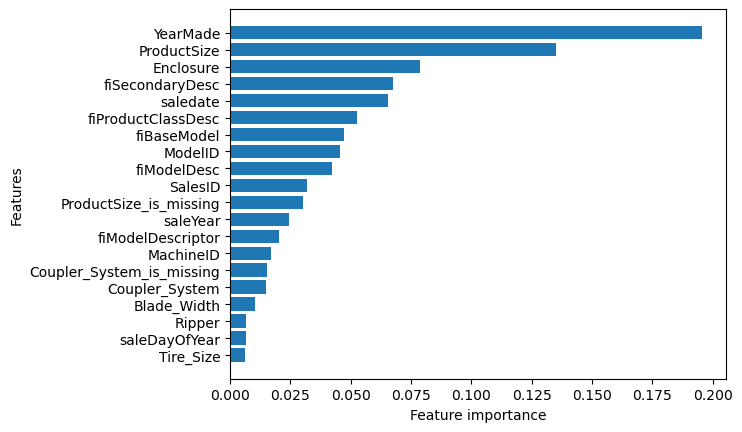

In [82]:
plot_features(X_train.columns, ideal_model.feature_importances_)

The year the bulldozer was made (YearMade) is the most important feature

- This data can influence how we collect data in the future
- These are the most important features the model has found
- Model uses these features to drive predictions